In [8]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target

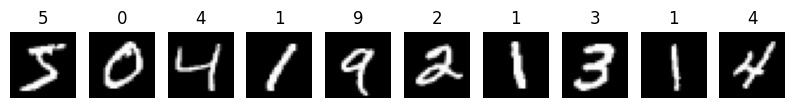

X: 70000  Y: 70000


In [9]:
import matplotlib.pyplot as plt

# Reshape one sample to 28x28 and plot first 10 images
fig, axes = plt.subplots(1, 10, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X.iloc[i].values.reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(y[i])

plt.show()
X = X/255
X = [X.iloc[i].values.reshape(28, 28).tolist() for i in range(X.shape[0])]
y = y.tolist()
print(f'X: {len(X)}  Y: {len(y)}')

In [ ]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from graphviz import Digraph
from src.nn import CNN, softmax
import random

network = CNN([(28, 28), (5, 5), 2, 2], [32, 10])

In [11]:
# Tracing and drawing graph

def trace(root):
    nodes, edges = set(), set()
    param_nodes = network.parameters()
    def build(node):
        if node not in nodes:
            nodes.add(node)

            if len(node._prev) == 0 and node not in param_nodes:
                node.label = "input"

            for n in node._prev:
                edges.add((n, node))
                build(n)
    
    build(root)
    return nodes, edges

def build_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # Left to right graph

    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))

        dot.node(name=uid, label=f'{node.label} | data {node.data:.4f} | grad {node.grad:.4f}', shape='record')

        if node._op:
            dot.node(name=uid+node._op, label=node._op)
            dot.edge(uid+node._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    
    return dot

In [12]:
def fetch_training_data(n=1000):
    r = random.randrange(0, 50000-n)
    return X[r:r+n], y[r:r+n]

def fetch_testing_data(n=1000):
    r = random.randrange(50000, 70000-n)
    return X[r:r+n], y[r:r+n]

def actual_inference(n):
    return [1 if i == n else 0 for i in range(10)]

In [13]:
# x_samp, y_samp = X[1], y[1]

# L = (network(x_samp)-targets[int(y_samp)])**2
# build_dot(L)

In [ ]:
training_cycles = 10
step = 0.005
exp_decay_factor = 0.95
batch_size = 100

for i in range(training_cycles):
    x_batch, y_batch = fetch_training_data(batch_size)

    outs = [network(ins) for ins in x_batch]
    losses = [-sum(o.log()*a for o, a in zip(out, actual_inference(int(exp)))) for out, exp in zip(outs, y_batch)]
    L = sum(losses) / len(losses)

    for p in network.parameters(): # Make sure to zero the grads!
        p.grad = 0
    
    L.backward() # Backward step

    for p in network.parameters(): # Modify weights based on grads
        p.data += -(step * exp_decay_factor)**i * p.grad
    
    print(f'Training step {i+1}: {L.data} loss')

Training step 1: 8.554332549660392 loss
Training step 2: 7.222700123561747 loss
Training step 3: 7.395852878856916 loss
Training step 4: 7.096010613301178 loss
Training step 5: 6.845322622943946 loss
Training step 6: 7.149886844876763 loss
Training step 7: 6.900811923759434 loss
Training step 8: 6.845177904625112 loss
Training step 9: 6.557751200135782 loss
Training step 10: 7.798856188358795 loss


In [ ]:
test = 100
correct = 0
x_batch, y_batch = fetch_testing_data(test)
for i in range(len(x_batch)):
    logits, actual = network(x_batch[i]), int(y_batch[i])
    print(f'Predicted: {pred}; Actual: {actual}')

    #if check_target(pred) == actual:
        #correct += 1
    
print(f'Predicted {correct} out of {test}')

Predicted: [Value(data=-0.3385363550342347, grad=0.0), Value(data=-0.06913174316984882, grad=0.0), Value(data=0.9315542845828015, grad=0.0), Value(data=-0.9992531605839869, grad=0.0), Value(data=0.9741338637016382, grad=0.0), Value(data=0.0343571676644228, grad=0.0), Value(data=0.9884784479756022, grad=0.0), Value(data=0.9942917586665782, grad=0.0), Value(data=0.9998778629512015, grad=0.0), Value(data=0.9941831603335559, grad=0.0)]; Actual: 9
Predicted: [Value(data=-0.2863662167001635, grad=0.0), Value(data=0.4760766688138871, grad=0.0), Value(data=0.9783486305989849, grad=0.0), Value(data=-0.9996505846434844, grad=0.0), Value(data=0.9582411949353511, grad=0.0), Value(data=0.17475482305382006, grad=0.0), Value(data=0.9720948848026273, grad=0.0), Value(data=0.9964244820173476, grad=0.0), Value(data=0.9998976429990323, grad=0.0), Value(data=0.9985524661156284, grad=0.0)]; Actual: 1
Predicted: [Value(data=0.026787617554128215, grad=0.0), Value(data=0.09063212580156381, grad=0.0), Value(da